In [1]:
# ================================
# 1. Import Dependencies
# ================================
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import joblib

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
stemmer = StemmerFactory().create_stemmer()


In [2]:
# ================================
# 2. Preprocessing Function
# ================================
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
stemmer = StemmerFactory().create_stemmer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return stemmer.stem(text)

In [3]:
# ================================
# 3. Load Dataset & Preprocessing
# ================================
print("📥 [Step 3] Load dan preprocessing data...")
data_path = os.path.join("..", "model", "kalimat_difficulty_100.xlsx")
df = pd.read_excel(data_path).dropna()

tqdm.pandas()
df["clean"] = df["kalimat"].progress_apply(preprocess_text)

📥 [Step 3] Load dan preprocessing data...


100%|██████████| 3000/3000 [02:14<00:00, 22.28it/s]


In [4]:
# ================================
# 4. TF-IDF Vectorization
# ================================
print("🧠 [Step 4] TF-IDF Vectorization...")
vectorizer = TfidfVectorizer(max_df=0.9, min_df=2)
X = vectorizer.fit_transform(df["clean"])

🧠 [Step 4] TF-IDF Vectorization...


📈 [Step 5] Elbow Method untuk cari jumlah cluster optimal...

📋 Tabel k, inertia, dan delta:
k	Inertia		Delta Inertia
2	2817.56		59.92
3	2782.37		35.20
4	2752.74		29.62
5	2729.24		23.51
6	2712.96		16.27
7	2691.13		21.83
8	2684.01		7.12
9	2658.08		25.93
10	2646.54		11.54


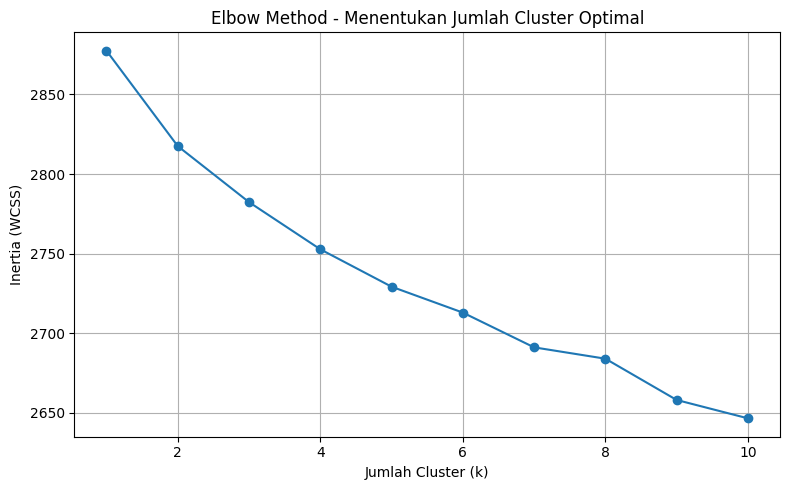

In [5]:
# ================================
# 5. Elbow Method (Cari k Optimal)
# ================================
print("📈 [Step 5] Elbow Method untuk cari jumlah cluster optimal...")
inertias = []
K_range = range(1, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertias.append(km.inertia_)

# Tabel Elbow
print("\n📋 Tabel k, inertia, dan delta:")
print("k\tInertia\t\tDelta Inertia")
for i in range(1, len(inertias)):
    delta = inertias[i-1] - inertias[i]
    print(f"{K_range[i]}\t{inertias[i]:.2f}\t\t{delta:.2f}")

# Plot Elbow
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method - Menentukan Jumlah Cluster Optimal")
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Inertia (WCSS)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# ================================
# 6. Clustering dengan KMeans
# ================================
n_clusters = int(input("\nMasukkan jumlah cluster optimal (k) hasil Elbow: "))
print(f"📊 [Step 6] Clustering dengan k={n_clusters}...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X)
df["cluster"] = kmeans.labels_

📊 [Step 6] Clustering dengan k=3...


🎨 [Step 7] Visualisasi hasil clustering dengan PCA 2D...


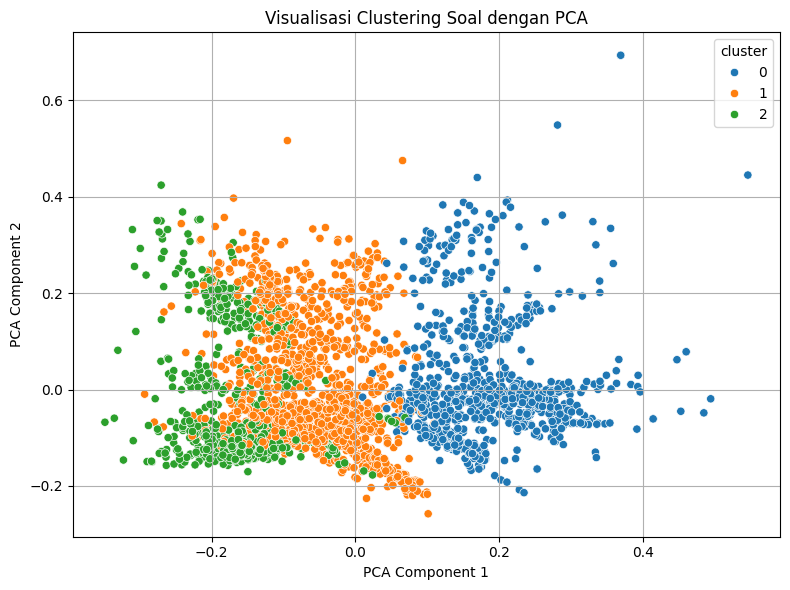

In [7]:
# ================================
# 7. PCA untuk Visualisasi 2D
# ================================
print("🎨 [Step 7] Visualisasi hasil clustering dengan PCA 2D...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())
df["x"] = X_pca[:, 0]
df["y"] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="x", y="y", hue="cluster", palette="tab10")
plt.title("Visualisasi Clustering Soal dengan PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:

# ================================
# 8. Tampilkan Contoh Soal per Cluster
# ================================
print("\n📄 [Step 8] Contoh Soal per Cluster:")
for i in range(n_clusters):
    print(f"\n🟦 Cluster {i}:")
    print(df[df["cluster"] == i]["kalimat"].sample(3, random_state=42).to_string(index=False))


📄 [Step 8] Contoh Soal per Cluster:

🟦 Cluster 0:
    Apa itu sistem remote access?
Apa itu peringatan “low battery”?
            Apa itu menu konteks?

🟦 Cluster 1:
Apa fungsi “data visualization” dalam dashboard?
           Jelaskan arti “Wi-Fi tidak tersedia”!
       Apa yang dimaksud dengan “update sistem”?

🟦 Cluster 2:
       Bagaimana SI menyimpan laporan multi-tahun?
Bagaimana sistem informasi dapat mendukung sist...
Bagaimana pengaruh transformasi digital terhada...


In [9]:

# ================================
# 9. Simpan Model dan Vectorizer
# ================================
model_path = os.path.join(  "..", "model", "kmeans_topic.pkl")
joblib.dump((kmeans, vectorizer), model_path)
print(f"\n✅ Model dan vectorizer disimpan ke: {model_path}")


✅ Model dan vectorizer disimpan ke: ..\model\kmeans_topic.pkl
